<a href="https://colab.research.google.com/github/blessjal/practicums/blob/master/breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

%matplotlib inline
plt.style.use('ggplot')

In [19]:
df = pd.read_csv('/content/sample_data/breast-cancer.data')

df.head()

,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no.1
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [20]:
 
columns = [ 'Class', 'age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
df.columns = columns
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [21]:
df.dtypes

Class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

In [22]:
X = df.drop('Class', axis=1)
y = df['Class']

X.shape, y.shape

((285, 9), (285,))

In [23]:

for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has '{unique_cat}' unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'age' has '6' unique categories
Feature 'menopause' has '3' unique categories
Feature 'tumor-size' has '11' unique categories
Feature 'inv-nodes' has '7' unique categories
Feature 'node-caps' has '3' unique categories
Feature 'breast' has '2' unique categories
Feature 'breast-quad' has '6' unique categories
Feature 'irradiat' has '2' unique categories


In [24]:
todummy_list = ['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat', 'age', 'tumor-size', 'inv-nodes']
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis=1)
        df = pd. concat([df, dummies], axis=1)
    return df

In [25]:
X = dummy_df(X, todummy_list)



In [26]:
X.isnull().sum().sort_values(ascending=False).head()

inv-nodes_9-11    0
age_40-49         0
age_20-29         0
irradiat_yes      0
irradiat_no       0
dtype: int64

In [27]:
def get_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    floor = x - 1.5 * iqr
    ceiling = x + 1.5 * iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values

In [29]:
tukey_indices, tukey_values = get_outliers_tukey(X['age'])
print(np.sort(tukey_values))

KeyError: ignored

In [30]:
def plot_histogram(x):
    plt.hist(x, color = 'blue', alpha=0.5)
    plt.title("Histogram of {var_name}".format(var_name=x.name))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

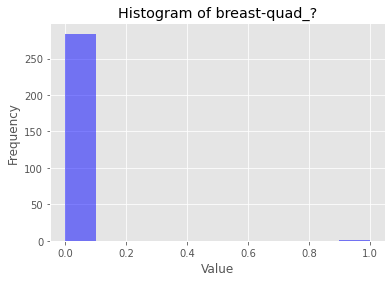

In [33]:
plot_histogram(X['breast-quad_?'])

In [35]:
def plot_histogram_rec(x, y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Rec=0')
    plt.hist(list(x[y==1]), alpha=0.5, label='Rec=1')
    plt.title("Histogram of {var_name} by DV Category".format(var_name=x.name))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

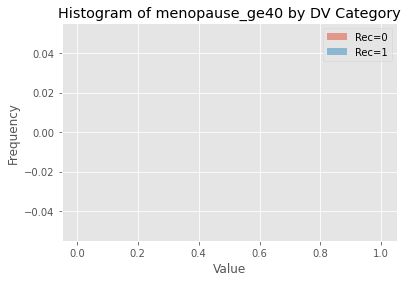

In [38]:
plot_histogram_rec(X['menopause_ge40'], y)

## Check for Interactions and Remove significant Interactions

In [39]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

In [40]:
def add_interactions(df):
    #get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    #find interactions
    poly = PolynomialFeatures(interaction_only = True, include_bias = False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    #remove interaction terms with all 0 values
    noint_indices = [i for i, x in enumerate(list((df == 0).all()))if x]
    df = df.drop(df.columns[noint_indices], axis=1)
    
    return df

In [41]:
X = add_interactions(X)
X.head()

,deg-malig,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,node-caps_yes,breast_left,breast_right,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,tumor-size_0-4,tumor-size_10-14,tumor-size_15-19,tumor-size_20-24,tumor-size_25-29,tumor-size_30-34,tumor-size_35-39,tumor-size_40-44,tumor-size_45-49,tumor-size_5-9,tumor-size_50-54,inv-nodes_0-2,inv-nodes_12-14,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_3-5,inv-nodes_6-8,...,age_70-79_inv-nodes_0-2,age_70-79_inv-nodes_9-11,tumor-size_0-4_inv-nodes_0-2,tumor-size_10-14_inv-nodes_0-2,tumor-size_10-14_inv-nodes_3-5,tumor-size_10-14_inv-nodes_6-8,tumor-size_15-19_inv-nodes_0-2,tumor-size_15-19_inv-nodes_12-14,tumor-size_15-19_inv-nodes_15-17,tumor-size_15-19_inv-nodes_6-8,tumor-size_15-19_inv-nodes_9-11,tumor-size_20-24_inv-nodes_0-2,tumor-size_20-24_inv-nodes_24-26,tumor-size_20-24_inv-nodes_3-5,tumor-size_20-24_inv-nodes_6-8,tumor-size_25-29_inv-nodes_0-2,tumor-size_25-29_inv-nodes_12-14,tumor-size_25-29_inv-nodes_15-17,tumor-size_25-29_inv-nodes_3-5,tumor-size_25-29_inv-nodes_6-8,tumor-size_25-29_inv-nodes_9-11,tumor-size_30-34_inv-nodes_0-2,tumor-size_30-34_inv-nodes_12-14,tumor-size_30-34_inv-nodes_15-17,tumor-size_30-34_inv-nodes_3-5,tumor-size_30-34_inv-nodes_6-8,tumor-size_30-34_inv-nodes_9-11,tumor-size_35-39_inv-nodes_0-2,tumor-size_35-39_inv-nodes_15-17,tumor-size_35-39_inv-nodes_6-8,tumor-size_35-39_inv-nodes_9-11,tumor-size_40-44_inv-nodes_0-2,tumor-size_40-44_inv-nodes_15-17,tumor-size_40-44_inv-nodes_3-5,tumor-size_40-44_inv-nodes_6-8,tumor-size_45-49_inv-nodes_0-2,tumor-size_45-49_inv-nodes_6-8,tumor-size_5-9_inv-nodes_0-2,tumor-size_50-54_inv-nodes_0-2,tumor-size_50-54_inv-nodes_9-11
0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality Reduction using PCA

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

X_pca = pd.DataFrame(pca.fit_transform(X))

X_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,2.974624,-2.806047,0.417706,-0.163285,-0.736882,1.315991,-1.025773,-0.508762,1.421597,-0.163631
1,1.269802,-1.211792,-3.868729,-0.533597,0.562373,1.544173,-0.836108,-1.909397,1.700447,0.336493
2,-2.034261,-2.194094,3.488823,-1.201068,1.227058,0.210023,-0.720955,-0.226375,-1.635134,0.276498
3,2.885793,-2.552770,0.094699,-0.509133,-0.513027,0.432338,-0.606070,0.530843,0.297987,-1.066957
4,-3.627114,-0.203887,-1.492604,-2.526399,0.745249,1.172636,-0.744247,-0.002182,-1.188251,0.224548


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199, 564), (86, 564), (199,), (86,))

In [44]:
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  9  17  37  49  57  77  86 112 122 126 127 144 156 175 176 185 193 207
 241 245 272 283 297 306 307 308 309 311 326 334 343 348 386 390 393 399
 406 410 414 440 448 454 458 459 468 481 516 521 525 532 534 536 538 544
 559] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [45]:
colnames_selected

['deg-malig',
 'node-caps_no',
 'node-caps_yes',
 'inv-nodes_0-2',
 'deg-malig_node-caps_yes',
 'deg-malig_breast_left',
 'deg-malig_irradiat_yes',
 'deg-malig_age_30-39',
 'menopause_ge40_inv-nodes_0-2',
 'menopause_premeno_node-caps_yes',
 'node-caps_no_irradiat_no',
 'node-caps_no_inv-nodes_0-2',
 'node-caps_yes_breast_left',
 'node-caps_yes_breast-quad_left_low',
 'breast_left_irradiat_yes',
 'breast_left_age_30-39',
 'breast_left_inv-nodes_6-8',
 'breast-quad_left_low_inv-nodes_6-8',
 'irradiat_no_inv-nodes_0-2',
 'irradiat_yes_inv-nodes_6-8']

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def find_model_perf(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    
    return auc

In [47]:
auc_processed = find_model_perf(X_train_selected, X_test_selected, y_train, y_test)
auc_processed

0.6698717948717948

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

def rf_model(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = [x[1] for x in rf.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_pred)
    return auc
  


In [55]:
rf_model(X_train_selected, X_test_selected, y_train, y_test)

0.6294871794871795

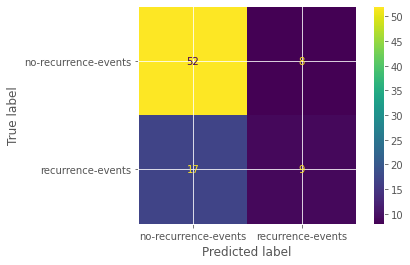

In [60]:
rf=RandomForestClassifier()
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)
plot_confusion_matrix(rf, X_test_selected, y_test)

In [62]:
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

no-recurrence-events       0.75      0.87      0.81        60
   recurrence-events       0.53      0.35      0.42        26

            accuracy                           0.71        86
           macro avg       0.64      0.61      0.61        86
        weighted avg       0.69      0.71      0.69        86



In [65]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(rf, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6703508771929824


In [69]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [74]:
from sklearn.model_selection import GridSearchCV
RandomForestClassifier()
# define grid
grid = {'n_estimators': [100, 200], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [int, None], 'bootstrap': [True, False] }

# define search
search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('The best parameters of the model: %s' % results.best_params_)

Mean Accuracy: 0.694
The best parameters of the model: {'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes': None, 'n_estimators': 200}


In [75]:
print('The best estimator of the model: ', results.best_estimator_)
print()
print('-'*100)
print('The best index of the model: ', results.best_index_)
print()
print('-'*100)
print('The best parameter of the model: ', results.best_params_)
print()
print('-'*100)
print('The best score of the model: ', results.best_score_)


The best estimator of the model:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

----------------------------------------------------------------------------------------------------
The best index of the model:  15

----------------------------------------------------------------------------------------------------
The best parameter of the model:  {'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes': None, 'n_estimators': 200}

-----------------------------------------------------

## Decision Tree Model

In [76]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_selected, y_train)
dt_pred = dt.predict(X_test_selected)

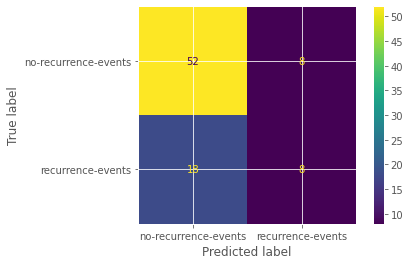

In [78]:
plot_confusion_matrix(dt, X_test_selected, y_test)

In [79]:
print(classification_report(y_test, dt_pred))

                      precision    recall  f1-score   support

no-recurrence-events       0.74      0.87      0.80        60
   recurrence-events       0.50      0.31      0.38        26

            accuracy                           0.70        86
           macro avg       0.62      0.59      0.59        86
        weighted avg       0.67      0.70      0.67        86



In [ ]:
DecisionTreeClassifier()

In [80]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(dt, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.683859649122807


In [81]:
DecisionTreeClassifier()
# define grid
grid = {'splitter': ['random', 'best'], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [int, None], 'max_features': ['auto', 'sqrt', 'log2']}

# define search
search = GridSearchCV(dt, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('The best parameters of the model: %s' % results.best_params_)

Mean Accuracy: 0.709
The best parameters of the model: {'criterion': 'entropy', 'max_features': 'log2', 'max_leaf_nodes': None, 'splitter': 'random'}


In [82]:
print('The best estimator of the model: ', results.best_estimator_)
print()
print('-'*100)
print('The best index of the model: ', results.best_index_)
print()
print('-'*100)
print('The best parameter of the model: ', results.best_params_)
print()
print('-'*100)
print('The best score of the model: ', results.best_score_)

The best estimator of the model:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

----------------------------------------------------------------------------------------------------
The best index of the model:  22

----------------------------------------------------------------------------------------------------
The best parameter of the model:  {'criterion': 'entropy', 'max_features': 'log2', 'max_leaf_nodes': None, 'splitter': 'random'}

----------------------------------------------------------------------------------------------------
The best score of the model:  0.7089473684210527
